## Import Statments

In [1]:
#Imports
#Data processing
import pandas as pd
import numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#ML libs
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

## Import Data

In [2]:
#Import features of each production well into dfProd
dfProd = pd.read_csv((r"../well_data/wellbore_data_producer_wells.csv"))

In [3]:
sandy_array = np.load(r"..\map_data\2d_sand_propotion.npy")
ai_array = np.load(r"..\map_data\2d_ai.npy")
sandy_shale = np.load(r"..\map_data\2d_sandy_shale_propotion.npy")
shale_array = np.load(r"..\map_data\2d_shale_propotion.npy")
shaly_sand = np.load(r"..\map_data\2d_shaly_sand_propotion.npy")
top_depth = np.load(r"..\map_data\2d_top_depth.npy")

## Data Prep

Instead of KNN or overall mean imputation, the following values should have a value that can be determined as an average over the entire well and applied (well-by-well imputation)

In [4]:
avg_features = ["Porosity, fraction", "Permeability, mD", "Compressible velocity, m/s","Youngs modulus, GPa", "Shear modulus, GPa","Shear velocity, m/s"]
avg_dict = {k:"mean" for k in avg_features}
dfProd["Well_ID"] = dfProd["Well_ID"].str[8:].astype(int)
dfWellAvg = dfProd.groupby(dfProd["Well_ID"]).agg(avg_dict)
print(dfWellAvg)
dfWellAvg.isna().sum()

         Porosity, fraction  Permeability, mD  Compressible velocity, m/s  \
Well_ID                                                                     
1                  0.133426        189.116974                 3392.897466   
2                  0.128885        176.367428                 3514.562352   
3                  0.118062        119.421584                 3972.826143   
4                  0.138111        151.595670                 3675.865373   
5                  0.130910        123.891145                 3790.337407   
...                     ...               ...                         ...   
69                 0.124074        166.810299                 3996.551094   
70                 0.139168        201.311447                 3308.578249   
71                 0.133675        105.286049                 3649.363331   
72                 0.109639         48.529438                 3899.275259   
73                 0.129752        101.693127                 3758.822664   

Porosity, fraction            0
Permeability, mD              0
Compressible velocity, m/s    0
Youngs modulus, GPa           0
Shear modulus, GPa            0
Shear velocity, m/s           0
dtype: int64

In [5]:
# Checking to make sure that nothing has an average value of 0 for anything, as that may mean that all values were NaN for a well
dfWellAvg.describe()
#Looks like we're okay

,"Porosity, fraction","Permeability, mD","Compressible velocity, m/s","Youngs modulus, GPa","Shear modulus, GPa","Shear velocity, m/s"
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,0.127886,113.409308,3692.465430,27.306561,5.751262,1676.124958
std,0.011534,53.227536,275.928692,2.132350,0.447604,22.791342
min,0.103266,17.692998,3226.716917,23.926022,4.952945,1629.142399
25%,0.119792,77.784480,3444.442189,25.499713,5.331215,1657.608521
50%,0.128884,99.067583,3688.453880,27.021138,5.708991,1676.017976
75%,0.134574,141.908305,3906.539696,29.041203,6.137787,1690.990515
max,0.163979,262.406426,4355.738959,31.787065,6.593852,1727.196584


In [6]:
WellAvgdict = dfWellAvg.to_dict()

In [7]:
dfProd["Rock facies"].unique()

array(['Sandstone', 'Sandy shale', 'Shaly sandstone', nan, 'Shale'],
      dtype=object)

In [8]:
ordinal_mapper = {'Sandstone': 3, 'Sandy shale': 1, 'Shaly sandstone': 2, 'Shale': 0}
dfProd['Rock facies'] = dfProd['Rock facies'].replace(ordinal_mapper)

In [9]:
dfProd.dtypes

Well_ID                           int32
X, m                              int64
Y, m                              int64
Depth, m                        float64
Porosity, fraction              float64
Permeability, mD                float64
Acoustic Impedance, kg*s/m^2    float64
Rock facies                     float64
Density, g/cm3                  float64
Compressible velocity, m/s      float64
Youngs modulus, GPa             float64
Shear velocity, m/s             float64
Shear modulus, GPa              float64
dtype: object

## Row Combination

In [10]:
imputer = KNNImputer(n_neighbors=3)

In [11]:
dfProd.describe()

,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
count,1460.000000,1460.000000,1460.000000,1460.000000,1268.000000,284.000000,1.357000e+03,1330.000000,1248.000000,1276.000000,1261.000000,1270.000000,1285.000000
mean,37.000000,4188.698630,5770.890411,3055.810959,0.127746,112.182739,7.325786e+06,2.185714,2.052521,3688.657853,27.288877,1676.158075,5.752640
std,21.078527,1771.495039,2389.773641,4.353335,0.036020,80.894436,3.101125e+05,0.960126,0.417622,727.216238,5.424608,100.630094,1.518699
min,1.000000,1175.000000,775.000000,3045.620000,0.040270,2.214604,6.559277e+06,0.000000,1.421943,1661.828496,13.205134,1307.887097,1.650985
25%,19.000000,2925.000000,3825.000000,3052.720000,0.113953,51.540980,7.111056e+06,2.000000,1.734052,3178.389486,23.466538,1608.928309,4.757475
50%,37.000000,3875.000000,6125.000000,3055.790000,0.137495,93.980722,7.274333e+06,2.000000,1.988542,3664.196826,26.647466,1674.836574,5.610267
75%,55.000000,5325.000000,7625.000000,3058.982500,0.152325,154.584890,7.503378e+06,3.000000,2.229507,4214.924966,30.874629,1746.081251,6.600503
max,73.000000,7975.000000,9775.000000,3066.300000,0.188910,489.219402,8.249272e+06,3.000000,3.530373,6179.653016,48.123292,1989.829247,11.820038


In [12]:
dfProd.isna().sum()

Well_ID                            0
X, m                               0
Y, m                               0
Depth, m                           0
Porosity, fraction               192
Permeability, mD                1176
Acoustic Impedance, kg*s/m^2     103
Rock facies                      130
Density, g/cm3                   212
Compressible velocity, m/s       184
Youngs modulus, GPa              199
Shear velocity, m/s              190
Shear modulus, GPa               175
dtype: int64

In [13]:
X = dfProd.drop("Well_ID", axis=1)

In [14]:
dfProdimputed = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)

In [15]:
dfProduced = pd.read_csv(r"..\prod_data\production_history.csv")

In [16]:
dfProduced["Well_ID"] = dfProduced["Well_ID"].str[8:].astype(int)

In [17]:
dfWells = dfProd.groupby(dfProd["Well_ID"]).mean()

In [18]:
dfProd_indexed = dfProduced.set_index("Well_ID")

In [19]:
dfProdFull = pd.concat([dfWells, dfProd_indexed], axis=1)

In [20]:
unneeded = ["Cumulative oil production (1 yr), MSTB", 
              "Cumulative oil production (2 yr), MSTB",
              "Cumulative Water production (1 yr), MSTB", 
              "Cumulative Water production (2 yr), MSTB", 
              "Cumulative Water production (3 yr), MSTB"]
dfProdFinal = dfProdFull.drop(unneeded, axis=1)
dfProdFinal.corr()

,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa","Cumulative oil production (3 yr), MSTB"
"X, m",1.000000,0.457665,-0.093746,0.293142,0.254115,-0.338710,0.538345,0.520609,-0.531674,-0.502162,-0.070208,0.434179,0.222396
"Y, m",0.457665,1.000000,0.112255,0.238360,0.158341,-0.264973,0.385094,0.510437,-0.500309,-0.489815,-0.020894,0.384918,0.037999
"Depth, m",-0.093746,0.112255,1.000000,-0.175716,-0.217101,0.188775,-0.175619,-0.162886,0.276573,0.269352,-0.146121,-0.175220,-0.486005
"Porosity, fraction",0.293142,0.238360,-0.175716,1.000000,0.657208,-0.890418,0.862297,0.243881,-0.467441,-0.541068,-0.001359,0.177810,0.763920
"Permeability, mD",0.254115,0.158341,-0.217101,0.657208,1.000000,-0.716629,0.558934,0.277257,-0.449660,-0.518060,-0.134847,0.290709,0.692084
"Acoustic Impedance, kg*s/m^2",-0.338710,-0.264973,0.188775,-0.890418,-0.716629,1.000000,-0.848267,-0.263932,0.475904,0.562357,0.051557,-0.170844,-0.722983
Rock facies,0.538345,0.385094,-0.175619,0.862297,0.558934,-0.848267,1.000000,0.449704,-0.568906,-0.660525,-0.041267,0.353018,0.643482
"Density, g/cm3",0.520609,0.510437,-0.162886,0.243881,0.277257,-0.263932,0.449704,1.000000,-0.873507,-0.862518,0.071725,0.819730,0.193598
"Compressible velocity, m/s",-0.531674,-0.500309,0.276573,-0.467441,-0.449660,0.475904,-0.568906,-0.873507,1.000000,0.883706,-0.159817,-0.757241,-0.425556
"Youngs modulus, GPa",-0.502162,-0.489815,0.269352,-0.541068,-0.518060,0.562357,-0.660525,-0.862518,0.883706,1.000000,-0.079031,-0.717516,-0.444470


In [21]:
X = dfProdFinal.drop(["Cumulative oil production (3 yr), MSTB"], axis=1)
y = dfProdFinal["Cumulative oil production (3 yr), MSTB"]

In [22]:
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1)

## XGB Regression

In [23]:
model = xgb.XGBRFRegressor(random_state=1)

In [24]:
model.fit(train_X, train_y)

XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=12, num_parallel_tree=100,
               objective='reg:squarederror', random_state=1, reg_alpha=0,
               scale_pos_weight=1, tree_method='exact', validate_parameters=1,
               verbosity=None)

In [25]:
preds = model.predict(test_X)

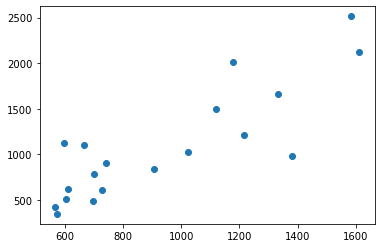

In [26]:
plt.scatter(preds, test_y)

In [27]:
mae = mean_absolute_error(preds, test_y)

In [28]:
print(mae)

287.3131459446957


In [29]:
test_y.mean()

1093.101052631579

In [30]:
print("Percent Error: ", mae/test_y.mean())

Percent Error:  0.2628422553001898


## Linear Regression

In [31]:
X_no_depth = X.drop("Depth, m", axis=1)

In [32]:
train_X_no_depth, test_X_no_depth, train_y, test_y = train_test_split(X_no_depth, y, random_state=1)

In [33]:
lin_model = LinearRegression()

In [34]:
lin_model.fit(train_X_no_depth, train_y)

LinearRegression()

In [35]:
lin_preds = lin_model.predict(test_X_no_depth)

In [36]:
lin_mae = mean_absolute_error(lin_preds, test_y)

In [37]:
print("Percent Error: ", lin_mae/test_y.mean())

Percent Error:  0.23521824354677287


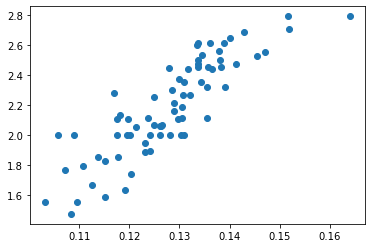

In [38]:
plt.scatter(dfProdFull["Porosity, fraction"], dfProdFull["Rock facies"])

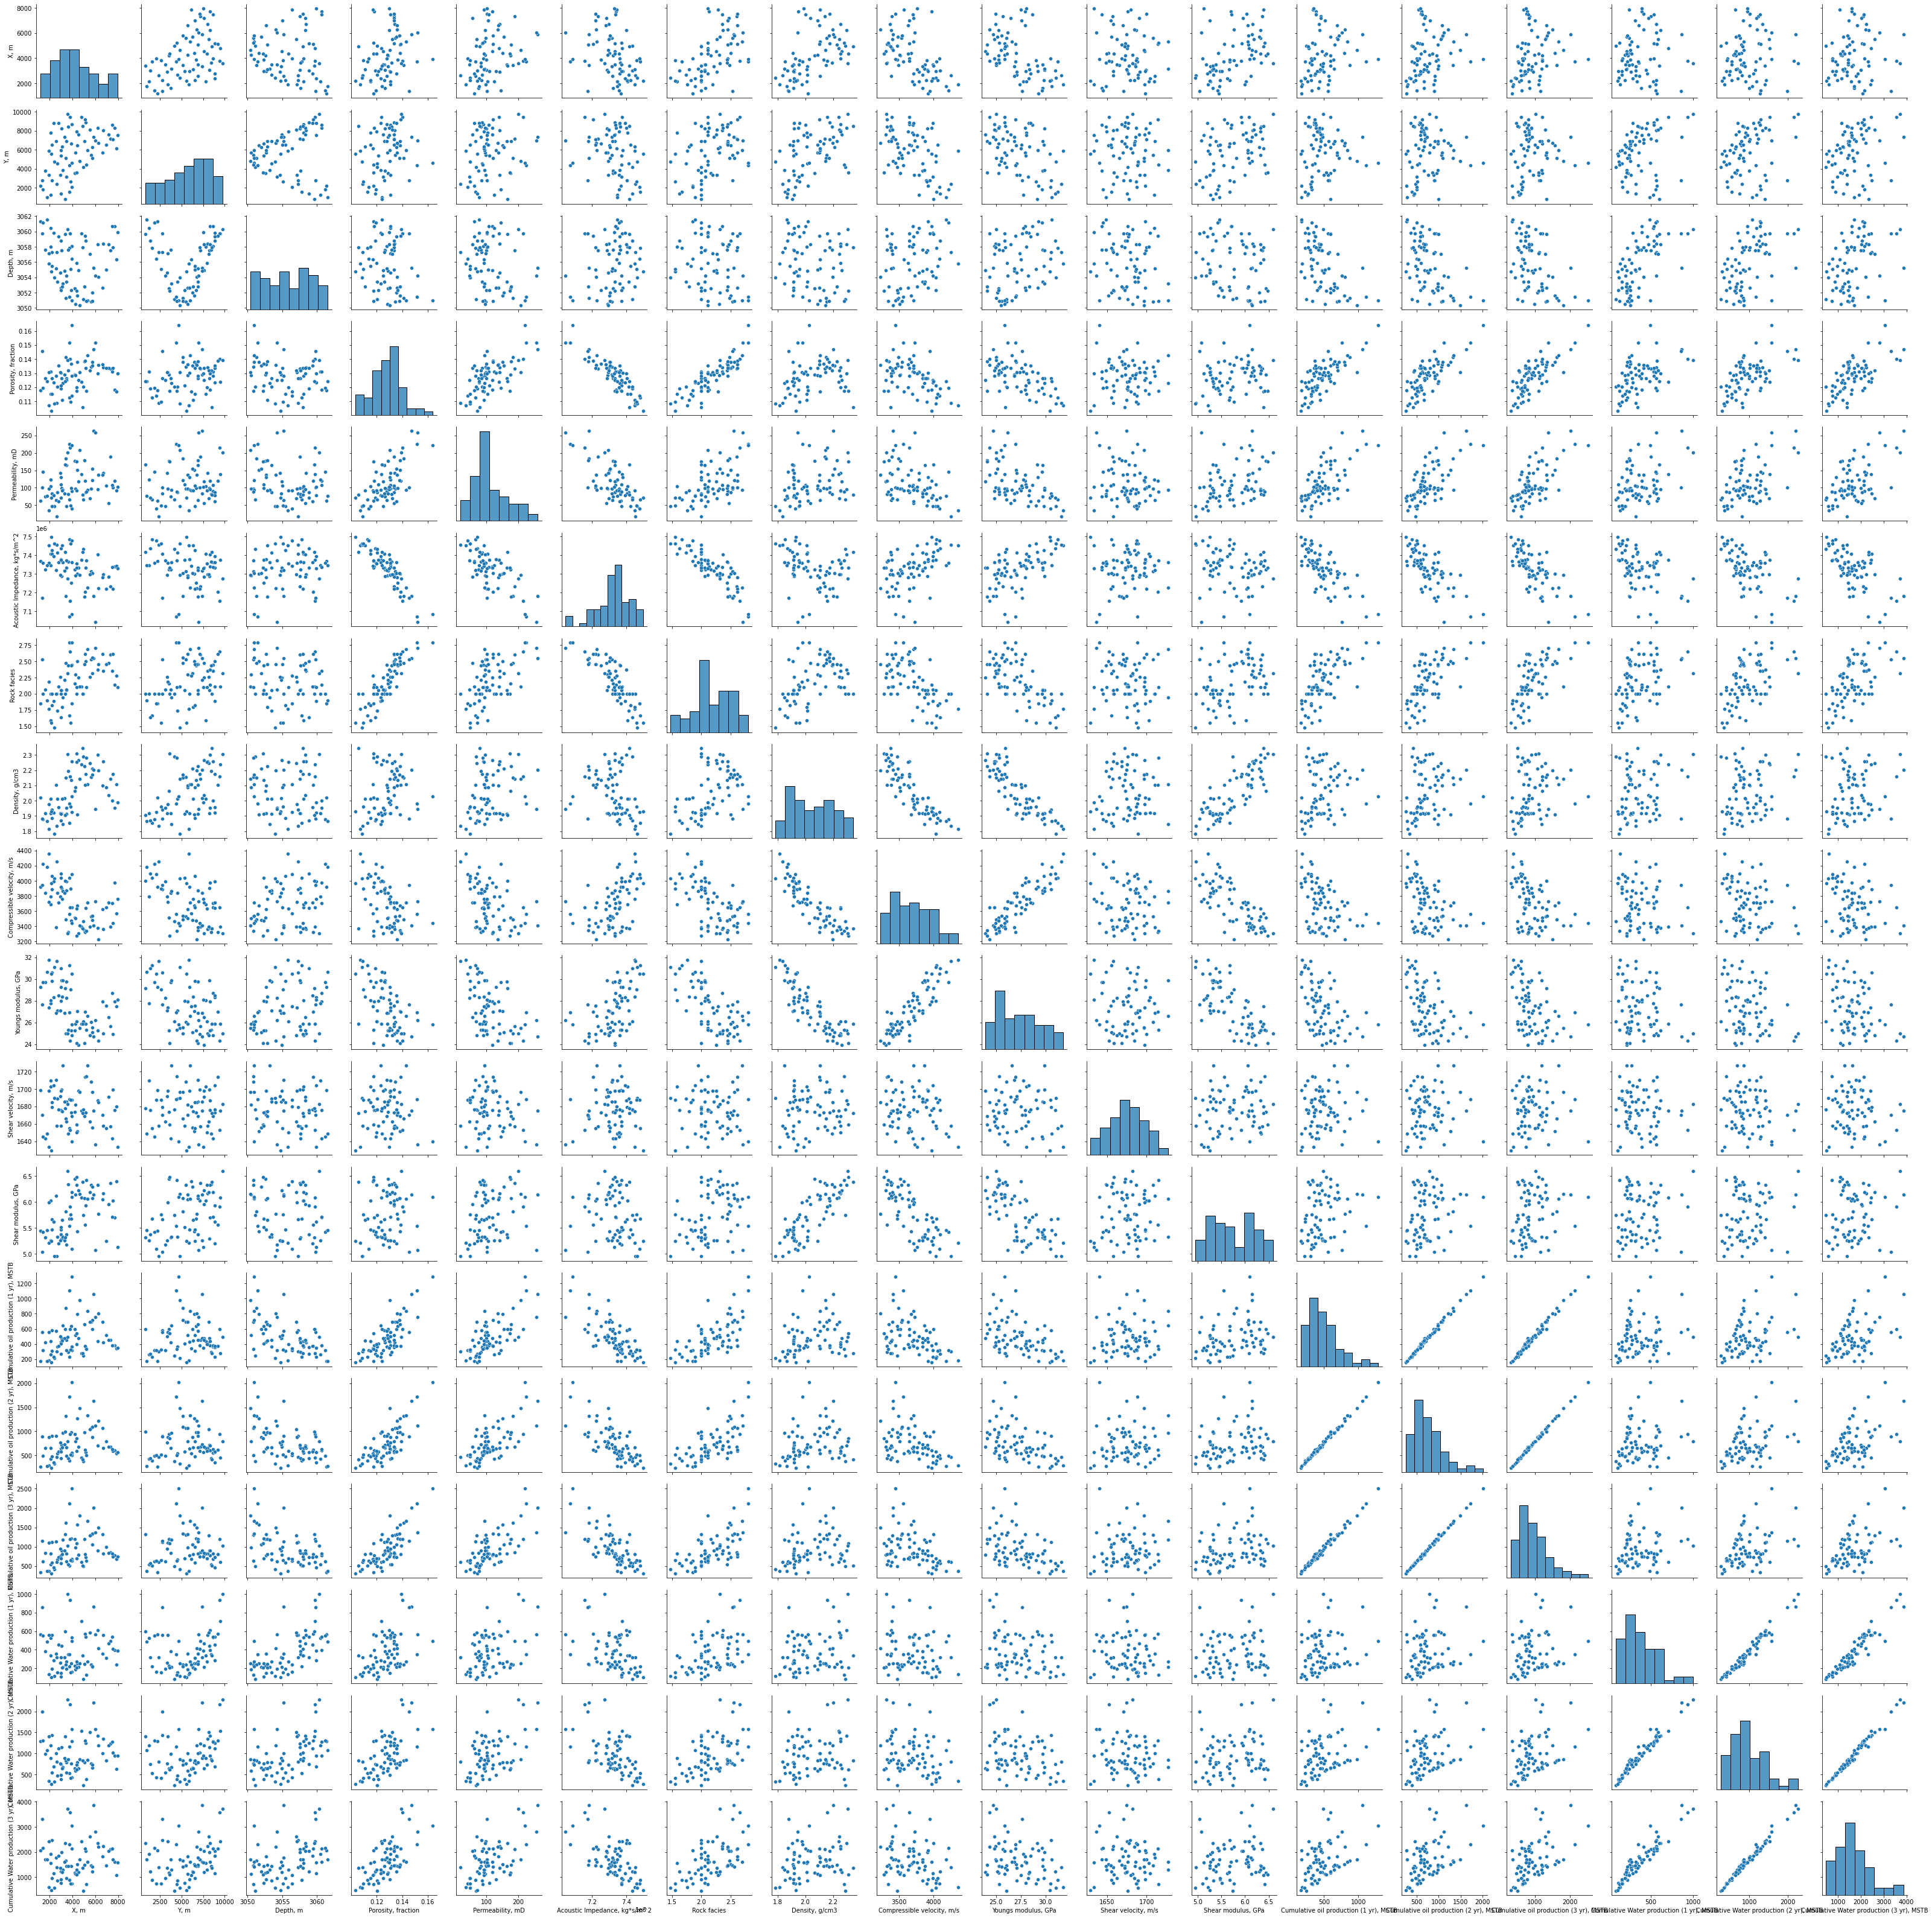

In [39]:
sns.pairplot(dfProdFull)

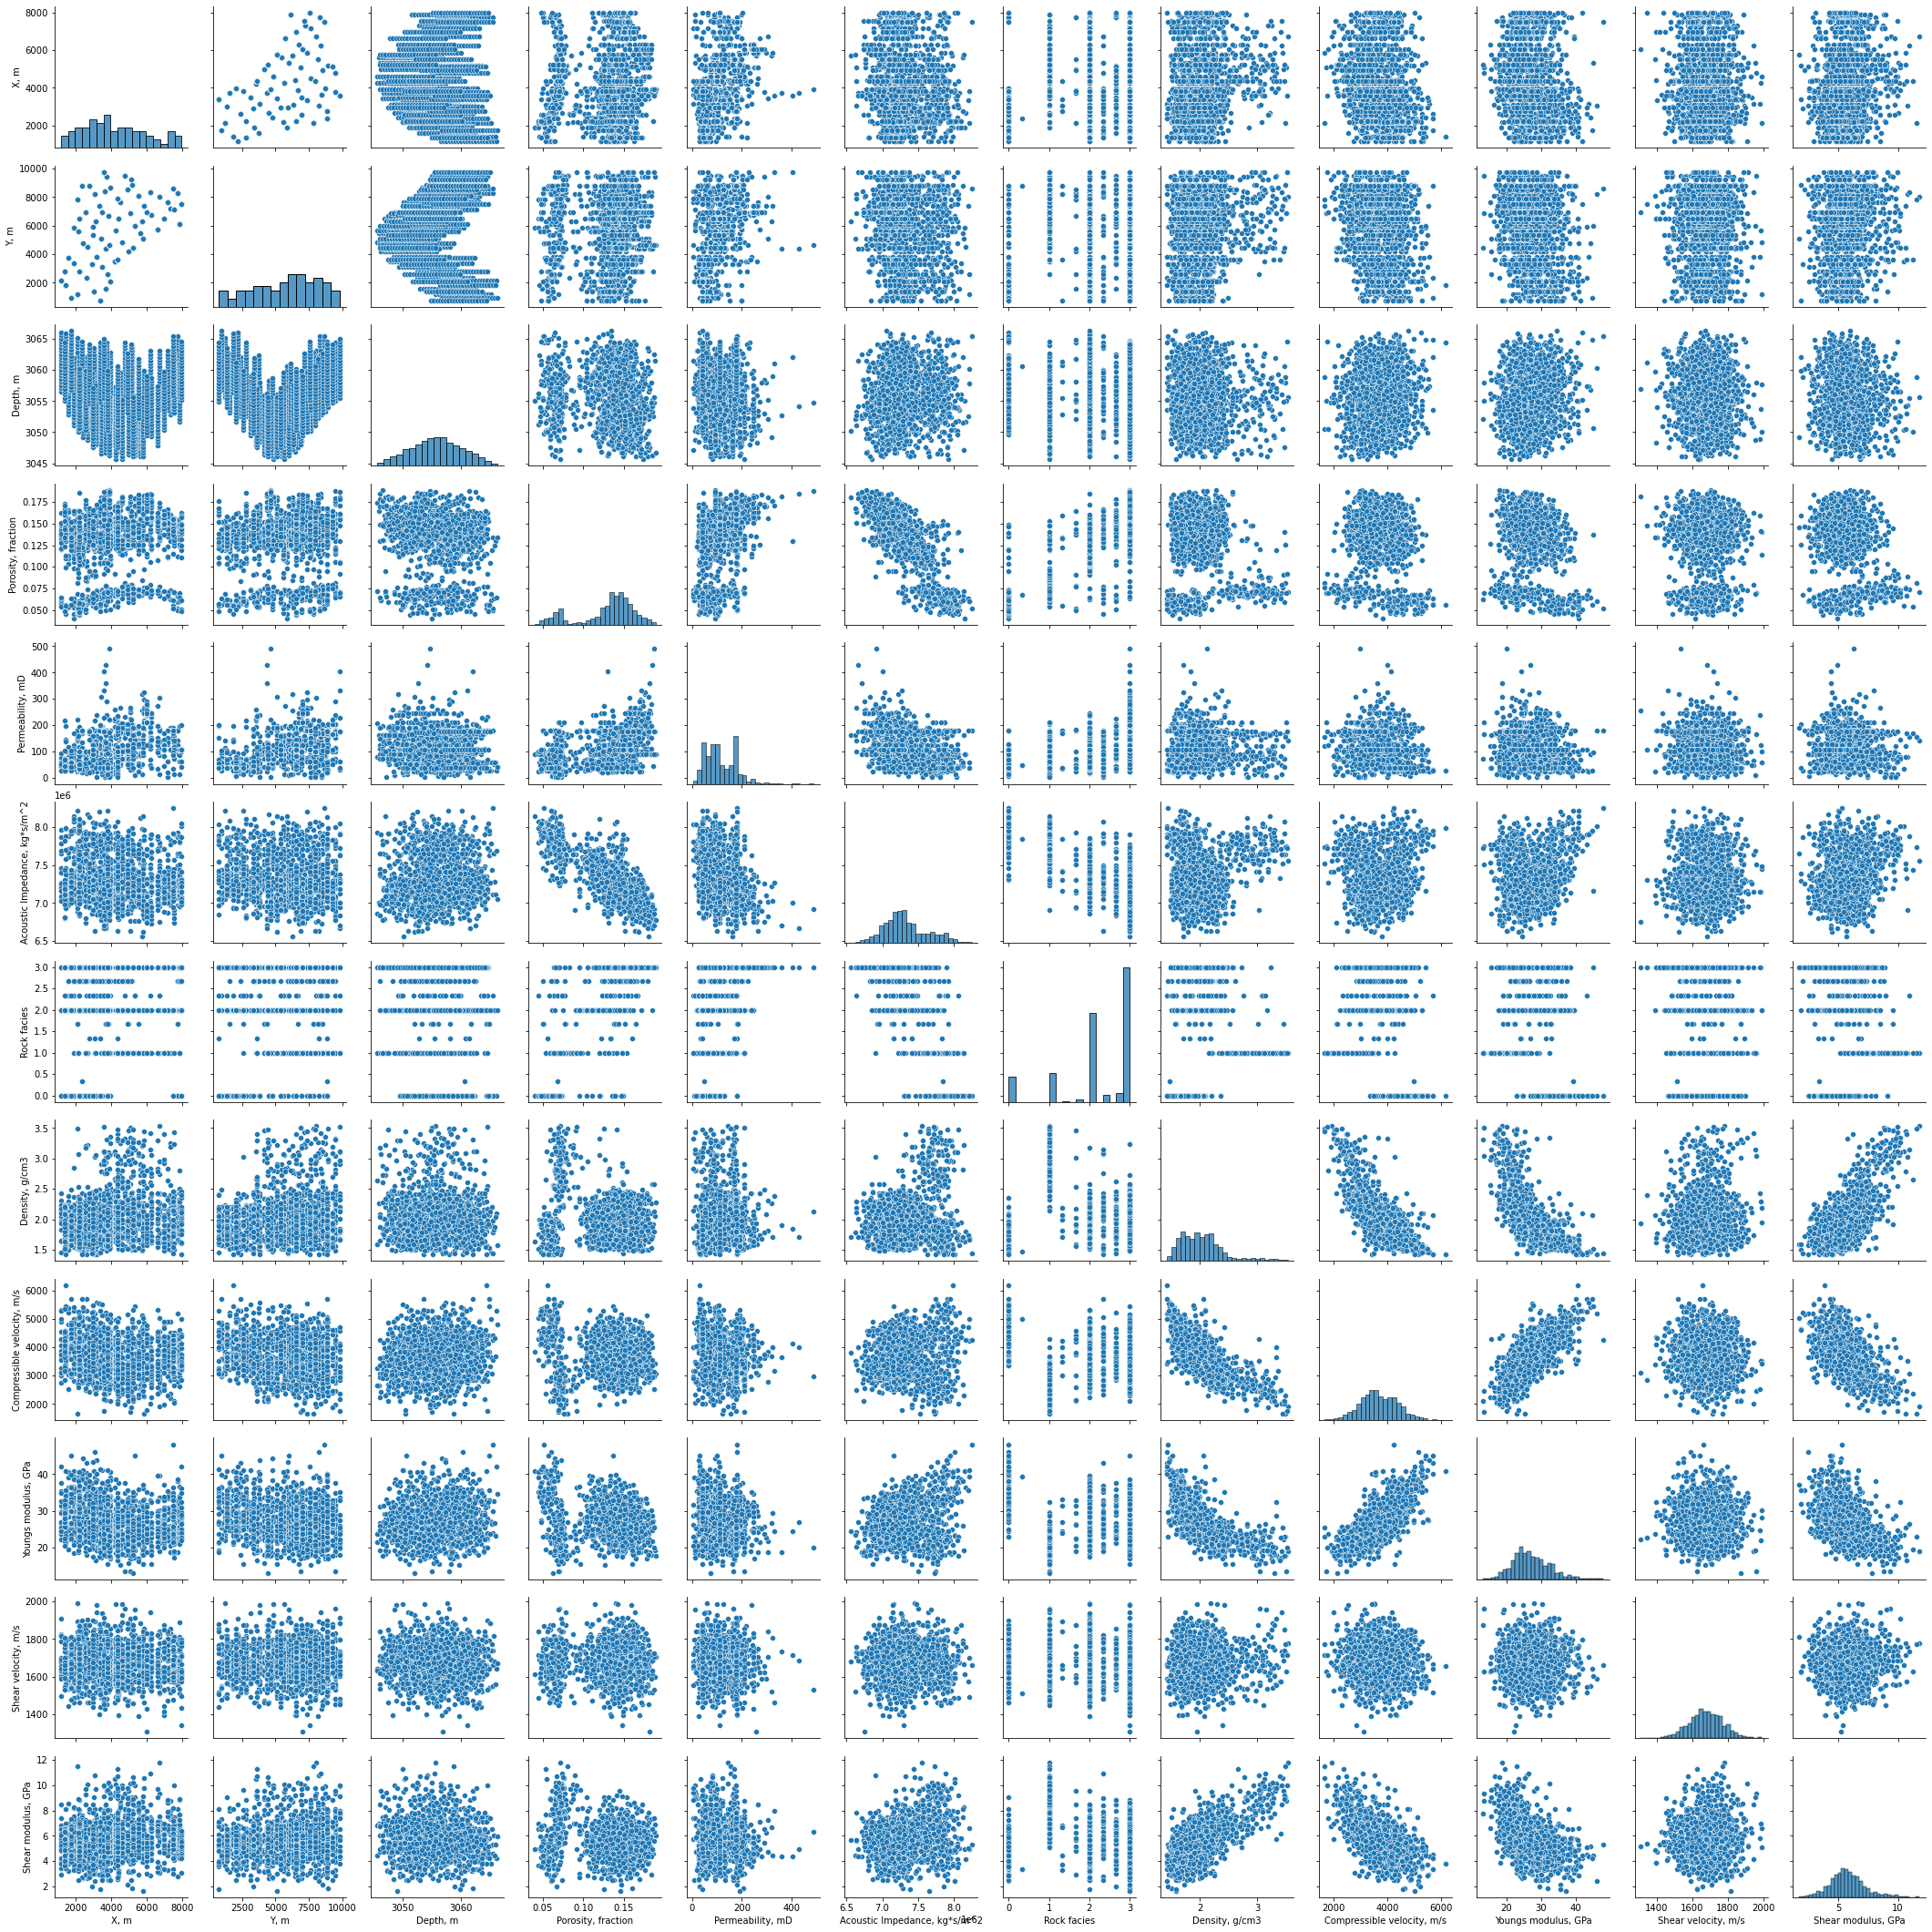

In [40]:
sns.pairplot(dfProdimputed)